In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
import torch
import random
import spacy
import pytextrank
import logging
from tqdm import tqdm
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer,RobertaTokenizer, LongformerTokenizer,  BigBirdTokenizerFast
from transformers import BertForSequenceClassification, RobertaForSequenceClassification, LongformerForSequenceClassification, BigBirdForSequenceClassification
from transformers import TrainingArguments, Trainer

In [2]:
# Summarize the input to how many tokens, default to 512 for BERT use.
# Since LongFormer could accept 4096 tokens, we could skip TextRank if LongFormer
seed_val = 42
ENABLE_TEXT_RANK = False
TEXT_RANK_LENGTH = 512

MODEL = "bert" # Choose from "bert", "roberta", "longformer", "bigbird"

TRAIN_DATA_PATH = "data/ds1_train.csv"
TEST_DATA_PATH = "data/ds1_test.csv"
DATASET = "ds1" if "ds1" in TRAIN_DATA_PATH else "ds2"
LEARNING_RATE = 2e-5
NUM_EPOCHS = 4

In [3]:
# If there's a GPU available...
# If GPU not available, training will cost SEVERAL DAYS, not recommended running on CPU
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU insteadp(not recommended).')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce GTX 1070


In [4]:
# Set the seed value all over the place to make this reproducible.
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [5]:
train = pd.read_csv(TRAIN_DATA_PATH)
test = pd.read_csv(TEST_DATA_PATH)

In [6]:
print(train.shape)
train.head()

(2120, 3)


,label,text,label_id
0,fantasy,"in the early days of the conquest, when the r...",0
1,fantasy,long before she was the terror of wonderland t...,0
2,fantasy,we see you. now we are you. no real witch woul...,0
3,fantasy,arch swindler moist van lipwig never believed ...,0
4,fantasy,tithe follows the story of sixteen year old a...,0


In [7]:
train["label"].value_counts()

fantasy       300
science       300
crime         300
history       300
horror        300
thriller      300
psychology     80
romance        80
sports         80
travel         80
Name: label, dtype: int64

In [8]:
#Load the model, if no model to load, initialize all the model and tokenizer for further use.

checkpoint_path = "Model.pth"  # Change to your preferred location

# Suppress transformers warnings
logging.getLogger("transformers").setLevel(logging.ERROR)

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    losses = checkpoint['losses']
    print("Loaded checkpoint.")
else:
    print("Loading models...")
    tokenizer_options = {
        "bert": BertTokenizer.from_pretrained('bert-base-uncased'),
        "roberta": RobertaTokenizer.from_pretrained('roberta-base'),
        "longformer": LongformerTokenizer.from_pretrained('allenai/longformer-base-4096'),
        "bigbird":  BigBirdTokenizerFast.from_pretrained('google/bigbird-roberta-base')
    }


    
    model_options = {
        "bert": BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(train['label_id'].unique())),
        "roberta": RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=len(train['label_id'].unique())),
        "longformer": LongformerForSequenceClassification.from_pretrained('allenai/longformer-base-4096', num_labels=len(train['label_id'].unique())),
        "bigbird": BigBirdForSequenceClassification.from_pretrained('google/bigbird-roberta-base', num_labels=len(train['label_id'].unique()))
    }
    print('done')
    

# Restore default logging level for transformers
logging.getLogger("transformers").setLevel(logging.WARNING)

Loading models...
done


By now, data has been cleaned. Next step is to tokenize, train, and test.
The first step is to use TextRank from Gensim to rank the first few sentences, and then we will train on BERT and RoBERTA to see its' performance.

# Text Rank by Spacy:
Note that this could be skipped.

In [9]:
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("textrank")

def summarize(input_text: str, max_tokens: int = 512):
    # Load a SpaCy model. For example, the English model.


    # Parse the document with SpaCy.
    doc = nlp(input_text)

    # If the text is less than 512 words, return the original text.
    if len(doc) <= max_tokens:
        return input_text

    # Extract the phrases using TextRank.
    phrases = ", ".join([p.text for p in doc._.phrases])

    summarized_doc = []  # Initialize an empty list to store the summarized sentences

    # Iterate over the sentences generated by textrank.summary and append them to the list
    for sent in doc._.textrank.summary(limit_sentences=50):
        summarized_doc.append(sent)


    # Join the sentences to form the summary.
    summary = " ".join([span.text for span in summarized_doc])

    # If the summary is longer than max_tokens, truncate it.
    if len(summary.split()) > max_tokens:
        summary = " ".join(summary.split()[:max_tokens])

    return summary

In [10]:
if (ENABLE_TEXT_RANK):
    print("\n-----------------------Progressing---------------------\n")
    try:
        train["text"] = train["text"].apply(summarize)
        test["text"] = test["text"].apply(summarize)
    except Exception as e:
        print("An error occurred while applying text_rank:", str(e))
    print("\n-----------------------Done---------------------\n")
else:
    print('TextRank has been skipped')

TextRank has been skipped


# Tokenize the data

In [11]:
train.head()

,label,text,label_id
0,fantasy,"in the early days of the conquest, when the r...",0
1,fantasy,long before she was the terror of wonderland t...,0
2,fantasy,we see you. now we are you. no real witch woul...,0
3,fantasy,arch swindler moist van lipwig never believed ...,0
4,fantasy,tithe follows the story of sixteen year old a...,0


In [12]:
train_text = train.text.values
train_labels = train.label_id.values

test_text = test.text.values
test_labels = test.label_id.values

In [13]:
train_text.shape

(2120,)

In [14]:
# Use the selected tokenizer
tokenizer = tokenizer_options.get(MODEL)

if MODEL in ["bert", "roberta"]:
    MODEL_MAX_TOKEN = 512
elif MODEL in ["longformer", "bigbird"]:
    MODEL_MAX_TOKEN = 2048
else:
    raise ValueError("Invalid model specified.")

# Tokenize the text
def tokenize_text(text, max_length=MODEL_MAX_TOKEN):
    return tokenizer.batch_encode_plus(
        text.tolist(), 
        max_length=max_length, 
        padding='max_length', 
        truncation=True
    )

tokenized_train_texts = tokenize_text(train_text)
tokenized_test_texts = tokenize_text(test_text)

In [15]:
class TextClassificationDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Create the dataset
train_dataset = TextClassificationDataset(tokenized_train_texts, train['label_id'].values)
test_dataset = TextClassificationDataset(tokenized_test_texts, test['label_id'].values)

# Create the dataloader
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=True)

In [16]:
for i in range(len(train['label_id'].values)):
    if (train['label_id'].values[i]!=train_dataset[i]['labels']):
        print('not equal')
        

print(train['label_id'].values[500])
print('-----------------------------')
print(train_dataset[500]['labels'])
print('-----------------------------')
for batch in train_dataloader:
    print(batch)
    break


1
-----------------------------
tensor(1)
-----------------------------
{'input_ids': tensor([[ 101, 5622, 7952,  ...,    0,    0,    0],
        [ 101, 2095, 2214,  ..., 1997, 2437,  102],
        [ 101, 1996, 3117,  ...,    0,    0,    0],
        ...,
        [ 101, 2009, 4832,  ...,    0,    0,    0],
        [ 101, 1996, 2338,  ..., 2442, 2022,  102],
        [ 101, 2182, 2003,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'labels': tensor([4, 3, 4, 3, 6, 6, 4, 6])}


# train the model

In [ ]:
# Use the selected model
model = model_options.get(MODEL)

training_args = TrainingArguments(
    output_dir='./results',  # Directory to save checkpoints and final model
    num_train_epochs= NUM_EPOCHS,  # Number of training epochs
    learning_rate = LEARNING_RATE,
    save_strategy='epoch',
    save_total_limit = 1,
    logging_dir='./logs',  # Directory for storing logs
    logging_steps=200 
    evaluation_strategy='no',  # No evaluation during training
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
)
trainer.train()


In [20]:
# Extract the predicted labels and true labels from the evaluation results
y_pred = trainer.predict(test_dataset).predictions.argmax(axis=1)
y_true = test_dataset.labels

# Print the classification report
report = classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.88      0.77      0.82       576
           1       0.73      0.81      0.77       347
           2       0.55      0.78      0.64       200
           3       0.77      0.83      0.80       300
           4       0.61      0.72      0.66       300
           5       0.86      0.68      0.76       723
           6       0.67      0.80      0.73        20
           7       0.38      0.48      0.43        31
           8       0.59      1.00      0.74        20
           9       0.83      0.95      0.88        20

    accuracy                           0.75      2537
   macro avg       0.69      0.78      0.72      2537
weighted avg       0.77      0.75      0.75      2537



# Below are the code to fintune Model by using torch 

Starting epoch 0


Training: 100%|███████████████████████████████| 265/265 [03:35<00:00,  1.23it/s]


Saved checkpoint for epoch 0.


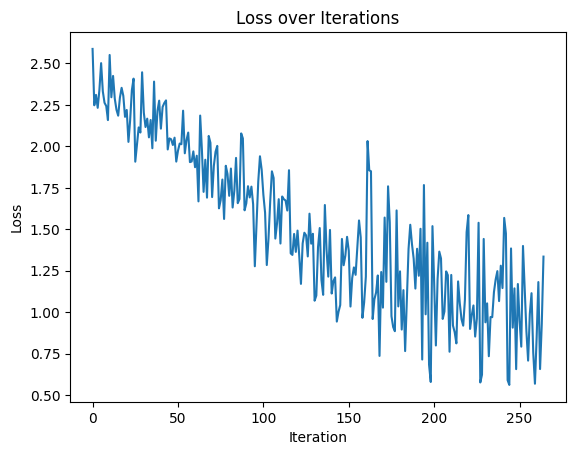

Starting epoch 1


Training: 100%|███████████████████████████████| 265/265 [03:48<00:00,  1.16it/s]


Saved checkpoint for epoch 1.


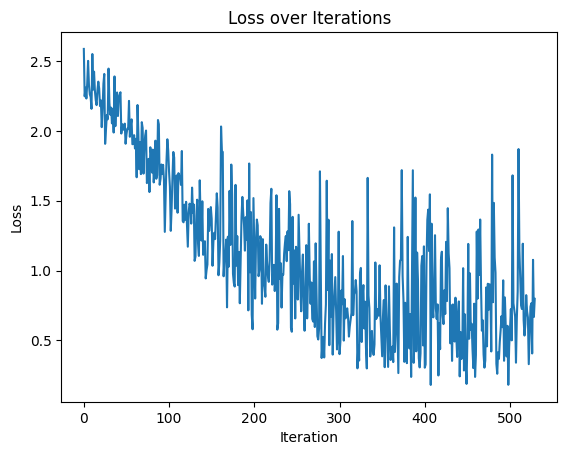

Starting epoch 2


Training: 100%|███████████████████████████████| 265/265 [03:54<00:00,  1.13it/s]


Saved checkpoint for epoch 2.


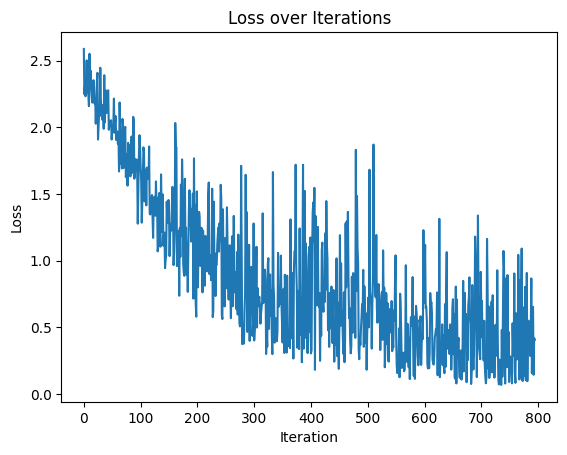

Starting epoch 3


Training: 100%|███████████████████████████████| 265/265 [03:58<00:00,  1.11it/s]


Saved checkpoint for epoch 3.


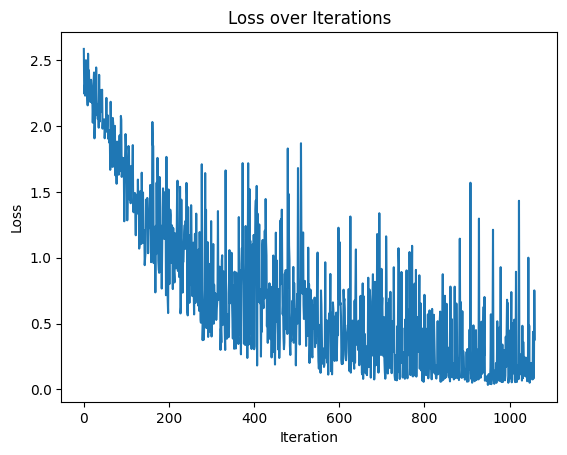

In [17]:
'''
# Use the selected model
model = model_options.get(MODEL)

# Initialize the optimizer
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)

# Move the model to the GPU
model.train()
model.to('cuda')

# Initialize a list to store the loss values
losses = []

checkpoint_path = f"{MODEL}_{DATASET}_TextRank_{ENABLE_TEXT_RANK}.pth" # Change to your preferred location

start_epoch = 0

# Load from checkpoint if it exists
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    losses = checkpoint['losses']
    print("Loaded checkpoint.")

# Training 
for epoch in range(start_epoch, NUM_EPOCHS):
    print(f"Starting epoch {epoch}")
    for batch in tqdm(train_dataloader, desc="Training"):
        batch = {k: v.to('cuda') for k, v in batch.items()}

        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        # Optimize the model parameters
        optimizer.step()
        optimizer.zero_grad()

        # Append the loss value to the list
        losses.append(loss.item())  

    # Save checkpoint after each epoch
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'losses': losses,
    }, checkpoint_path)
    print(f"Saved checkpoint for epoch {epoch}.")

    # Plot the loss values after each epoch
    plt.plot(losses)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Loss over Iterations')
    plt.show()

'''

Model now been trained, now evaluate the performance

In [ ]:
'''
#If yo have a trained model just want to evaluate it:
checkpoint_path = "Model.pth"  # Change to your preferred location
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    losses = checkpoint['losses']
    print("Loaded checkpoint.")
    

model.eval()
model.to('cuda')
predictions = []
true_labels = []

# Iterate over the test dataset
for batch in test_dataloader:
    batch = {k: v.to('cuda') for k, v in batch.items()}

    # Disable gradient calculation
    with torch.no_grad():
        # Perform inference
        outputs = model(**batch)
        
    predicted_values = outputs.logits
    predictions.extend(predicted_values)
    true_labels.extend(batch['labels'].tolist())

# Convert logits to predictions
predictions = [torch.argmax(item).item() for item in predictions]

# Make sure that true_labels is a list
assert isinstance(true_labels, list)

  
# Generate classification report
report = classification_report(true_labels, predictions)

print(report)

# Save the report to a file
with open(f'Classreport_{MODEL}_{DATASET}_TextRank_{ENABLE_TEXT_RANK}.txt', 'w') as file:
    file.write(report)

'''